In [1]:
import sys
import os
path_to_add = os.getcwd()+"/../filter_masks"
sys.path.append(path_to_add)
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import filter_masks
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from cycler import cycler
from scipy.signal import savgol_filter


In [2]:
#default plot setting
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgcmyk')
mpl.rcParams['figure.figsize'] = (8,8)
plt.rcParams['image.cmap'] = 'magma'
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['font.family'] = 'Arial'
#mpl.rcParams['font.serif'] = 'Computer Modern Roman'
#mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 10

#load data
experiment_run_name = "sxri0414run60"
my_file = experiment_run_name+".h5"
my_hdf5_object = h5py.File("../small_h5_data/"+my_file,"r")

#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    my_dict[i] = array(my_hdf5_object[i])
pixel_to_femtosecond_list = []
width_list = []

#no built in type for weighted binnsed statistic, 
#might be able to use sum instead of mean (or average)
def weighted_binned_statistic(x,y,weights,bins,statistic):
    binned_weighted_statistic = binned_statistic_dd(x,y*weights,bins=[my_bins],statistic=average)
    binned_weights = binned_statistic_dd(x,1.0*weights,bins=[my_bins],statistic=average)
    
    return  binned_weighted_statistic.statistic/binned_weights.statistic

#make mask
my_mask =  filter_masks.__dict__[experiment_run_name](my_dict)
my_mask *=  (my_dict['timeToolOpal/time_pixel']>300)
my_mask *=  (my_dict['timeToolOpal/time_pixel']<1600)
#my_mask *=  (my_dict['ebeam/photon_energy']>913.75)
#my_mask *=  (my_dict['ebeam/photon_energy']<914.25)

#my_mask *=  (my_dict['timeToolOpal/uncertainty_cov']*pixel_to_femtosecond<0.0002)

/reg/data/ana13/sxr/sxri0414/res/automated_analysis/for_pub/../filter_masks/filter_masks.py:14: RuntimeWarning: invalid value encountered in greater
  myMask = myMask * (array(myDict['gas_detector/f_11_ENRC'])>1)


In [3]:
#viewing  IvsI0 as function of energy (i.e. photon wavelength).  Are small wavelength fluctuations kill swamping the signal?
x = my_dict['GMD'][my_mask]
y = my_dict['acqiris2/amplitude'][my_mask]
sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
energy = my_dict['ebeam/photon_energy'][my_mask]
fee = my_dict['gas_detector/f_22_ENRC'][my_mask]

fee_difr = my_dict['gas_detector/f_12_ENRC'][my_mask]

my_bins = arange(900,935,0.2)

#defining truncated mean
def quartile_mean(x):
    return stats.trim_mean(x, 0.25)

In [4]:
#generate reference curve
IvsFEE_average = binned_statistic_dd(energy,y,bins=[my_bins],statistic=average).statistic
I0vsFEE_average = binned_statistic_dd(energy,x,bins=[my_bins],statistic=average).statistic

In [5]:
#showing I and I0 are shifted with respect to each other.
def gaussian(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+4e-2
    return a*exp(-(x-x0)**2/(2*sigma**2))
    
#plot(my_bins[:-1],IvsFEE_average)
popt, pcov = curve_fit(gaussian, my_bins[:-1][45:123],IvsFEE_average[45:123],p0=[914,5,1])

#plot(my_bins[:-1],gaussian(my_bins[:-1],popt[0],popt[1],popt[2]))
#twinx()

def gaussian_gmd(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+0.7e-4
    return a*exp(-(x-x0)**2/(2*sigma**2))

#plot(my_bins[:-1],I0vsFEE_average,'r')
popt, pcov = curve_fit(gaussian_gmd, my_bins[:-1][45:123],I0vsFEE_average[45:123],p0=[914,5,.0014])

#plot(my_bins[:-1],gaussian_gmd(my_bins[:-1],popt[0],popt[1],popt[2]),c='purple')
#ylim(-0.0000,0.00088)
#show()

In [6]:
#increment over fee value and generate I and I0 vs photon wavelength
#GMD_spectra_stack = []
#acq_spectra_stack = []

acq_spectra_amplitude = []
GMD_spectra_amplitude = []



fee_bin_size = .02
fee_bins = arange(0.30,0.7,fee_bin_size)
for i in fee_bins:
    
    fee_mask = ones(len(x)).astype(bool)
    fee_mask *= fee>i
    fee_mask *= fee<i+fee_bin_size
    
    popt = energy[fee_mask],y[fee_mask]
    popt, pcov = curve_fit(gaussian,energy[fee_mask],y[fee_mask],p0=[914,5,1])
    acq_spectra_amplitude.append(popt)
    
    popt, pcov = curve_fit(gaussian_gmd,energy[fee_mask],x[fee_mask],p0=[914,5,.0014])
    GMD_spectra_amplitude.append(popt)
    
    
#increment over fee value and generate I and I0 vs photon wavelength
#GMD_spectra_stack = []
#acq_spectra_stack = []

fee_bin_size = .05
fee_bins2 = arange(1.0,1.8,fee_bin_size)
for i in fee_bins2:
    
    fee_mask = ones(len(x)).astype(bool)
    fee_mask *= fee_difr>i
    fee_mask *= fee_difr<i+fee_bin_size
    
    popt = energy[fee_mask],y[fee_mask]
    popt, pcov = curve_fit(gaussian,energy[fee_mask],y[fee_mask],p0=[914,5,1])
    acq_spectra_amplitude.append(popt)
    
    popt, pcov = curve_fit(gaussian_gmd,energy[fee_mask],x[fee_mask],p0=[914,5,.0014])
    GMD_spectra_amplitude.append(popt)
    
fee_bins = append(fee_bins,fee_bins2)
my_slope = theilslopes(abs(array(acq_spectra_amplitude)).transpose()[2],abs(array(GMD_spectra_amplitude).transpose()[2]),alpha=0.95)


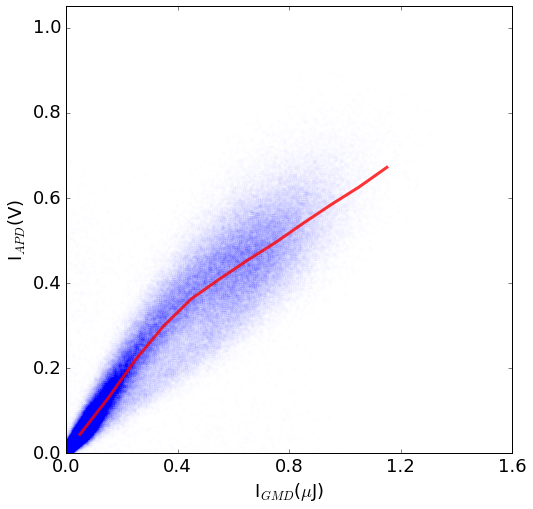

In [7]:
#this show the relationship between I and I0 is more linear after accoutning for different photon energy responses in 
#I and I0
f5, axarr5 = plt.subplots(1, sharex=True)
axarr5.plot(my_dict['GMD'],my_dict['acqiris2/amplitude'],'.',alpha=0.002,markersize=6.0)
#axarr5.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'ro',alpha=50)
my_slope= theilslopes(array(acq_spectra_amplitude).transpose()[2],array(GMD_spectra_amplitude).transpose()[2],alpha=0.95)
#axarr5.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'r-',linewidth=2,alpha=50)

my_hist = binned_statistic_dd(x,y,bins=[arange(0,0.0014,0.0001)],statistic=median).statistic
axarr5.plot((arange(0,0.0014,0.0001)[1:]+arange(0,0.0014,0.0001)[:-1])/2,my_hist,linewidth=3,alpha=.80,c='r',linestyle='solid')

#I_FEE_hist = binned_statistic_dd(fee,y,bins=[arange(0.05,0.85,0.02)],statistic=mean).statistic
#I0_FEE_hist = binned_statistic_dd(fee,x,bins=[arange(.05,0.85,0.02)],statistic='mean').statistic
#plot(I0_FEE_hist,I_FEE_hist,marker='o',color='purple',linewidth=0)

axarr5.set_xlim(0.000,0.0016)
axarr5.set_xticks(arange(0,.0017,.0004))
axarr5.set_xticklabels(["0.0","0.4","0.8","1.2","1.6"])
axarr5.set_ylim(0,1.05)
#axarr5.set_xlabel("I$_0$(mV)")
axarr5.set_xlabel(r"I$_{GMD}$($\mu$J)")
axarr5.set_ylabel("I$_{APD}$(V)")
show()

In [8]:
y_bins = arange(0,.8,0.02)
x_bins = arange(0,0.001,0.00002)
IvsI0_hist = binned_statistic_dd([y,x],1,bins=[y_bins,x_bins],statistic='count')
my_hist = binned_statistic_dd(x,y,bins=[arange(0,0.0011,0.00005)],statistic=median).statistic

In [9]:
def make_IvsI0(fee_start,fee_stop,start_range,stop_range):
    #start_range = 45
    #stop_range = 85
    fee_mask = ones(len(x)).astype(bool)
    fee_mask *= fee>fee_start
    fee_mask *= fee<fee_stop
    IvsFEE_average = binned_statistic_dd(energy[fee_mask],y[fee_mask],bins=[my_bins],statistic=average).statistic
    I0vsFEE_average = binned_statistic_dd(energy[fee_mask],x[fee_mask],bins=[my_bins],statistic=average).statistic
    return IvsFEE_average[start_range:-stop_range],I0vsFEE_average[start_range:-stop_range],my_bins[start_range:-stop_range]+mean(diff(my_bins))/2.0

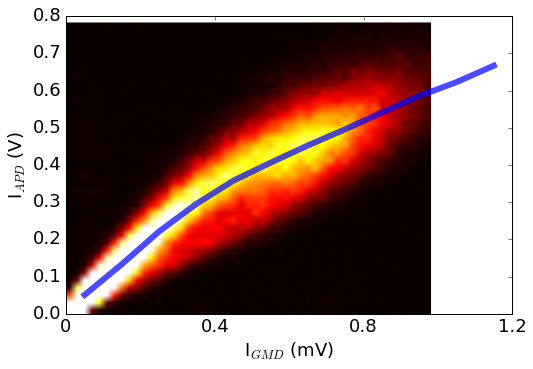

In [10]:
f2, axarr2 = plt.subplots(1, sharex=True)
axarr2.imshow((IvsI0_hist[0][::-1,:]+1),cmap='hot',interpolation='bilinear',clim=(0,400),extent=(0,max(x_bins),0,max(y_bins)),aspect=1.0/1e3)
axarr2.set_ylabel("I$_{APD}$ (V)")
axarr2.set_xlabel("I$_{GMD}}$ (mV)")

my_hist = binned_statistic_dd(x,y,bins=[arange(0,0.0014,0.0001)],statistic=mean).statistic
axarr2.plot((arange(0,0.0014,0.0001)[1:]+arange(0,0.0014,0.0001)[:-1])/2,my_hist,linewidth=6,alpha=0.7)
#plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'go')

#plot(arange(0,0.0011,0.00005)[:-1],my_hist,'b-',marker='o',linewidth=1)
axarr2.set_xlim(0,0.0012)
axarr2.set_xticks(arange(0,0.0014,0.0004))
axarr2.set_xticklabels(["0","0.4","0.8","1.2"])

#xlabel()
show()


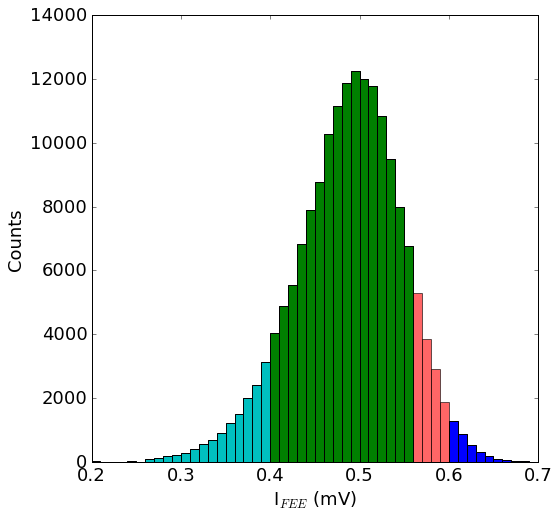

In [11]:
f6, axarr6 = plt.subplots(1, sharex=True)
axarr6.hist(fee,bins=arange(0.2,0.7,0.01),color='r',alpha=0.6)
axarr6.set_ylabel("Counts")
axarr6.set_xlabel("I$_{FEE}$ (mV)")

for i in [[.60,1],[.4,.56],[.0,.4]]:
    color_fee_mask = fee > i[0]
    color_fee_mask *= fee < i[1]
    axarr6.hist(fee[color_fee_mask],bins=arange(0.2,0.7,0.01),alpha=1)

show()

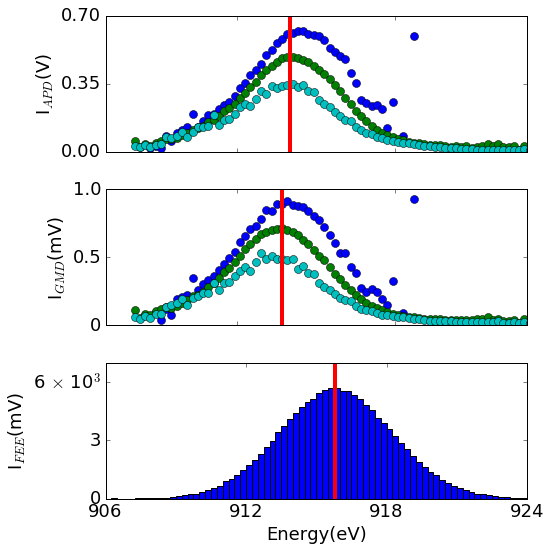

In [12]:
#fee weighted energy histogram
f, axarr = plt.subplots(3, sharex=True)

for i in [[.60,1],[.4,.56],[.0,.4]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],40,50)
    IvsE_moment = mean(nan_to_num(IvsFEE_average*e_bins[:-1]))/mean(nan_to_num(IvsFEE_average))
    I0vsE_moment = mean(nan_to_num(I0vsFEE_average*e_bins[:-1]))/mean(nan_to_num(I0vsFEE_average))
    axarr[0].plot(e_bins[:-1],IvsFEE_average,'o',markersize=8,alpha = 1.0)
    axarr[1].plot(e_bins[:-1],I0vsFEE_average,'o',markersize=8,alpha = 1.0)

energy_start_plot,energy_end_plot = 907,923
    
#axarr[0].set_xlabel("Energy(eV)")
axarr[0].set_ylabel("I$_{APD}$(V)")
axarr[0].set_xlim(energy_start_plot,energy_end_plot)
axarr[0].axvline(x=IvsE_moment,color='r',linewidth=4)
axarr[0].set_yticks(arange(0,0.71,0.7/2))
#axarr[0].set_yticklabels(["0","0.5","1.0"])

#axarr[1].set_xlabel("Energy(eV)")
axarr[1].set_ylabel("I$_{GMD}$(mV)")
axarr[1].set_xlim(energy_start_plot,energy_end_plot)
axarr[1].axvline(x=I0vsE_moment,color='r',linewidth=4)
axarr[1].set_yticks(arange(0,0.0011,0.0005))
axarr[1].set_yticklabels(["0","0.5","1.0"])

axarr[2].hist(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25),weights=nan_to_num(my_dict['gas_detector/f_21_ENRC']))
my_hist = histogram(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25))
#x_location = my_hist[1][argmax([my_hist[0]])]
x_location = mean(my_dict['ebeam/photon_energy'])
axarr[2].axvline(x=x_location,color='r',linewidth=4)

axarr[2].set_xlabel("Energy(eV)")
axarr[2].set_ylabel("I$_{FEE}$(mV)")

axarr[2].set_ylim(0,7e3)
axarr[2].set_xlim(energy_start_plot,energy_end_plot)
axarr[2].set_xticks(arange(906,925,6))
axarr[2].set_xticklabels(["906","912","918","924"])
axarr[2].set_yticks(arange(0,7100,3000))
axarr[2].set_yticklabels(["0","3",r"6 $ \times $ 10$^3$"])

#axarr[2].set_yticks(arange(0,12100,6000))
#axarr[2].set_yticklabels(["0","3",r"6 $ \times $ 10$^4$"])
f.tight_layout()

show()

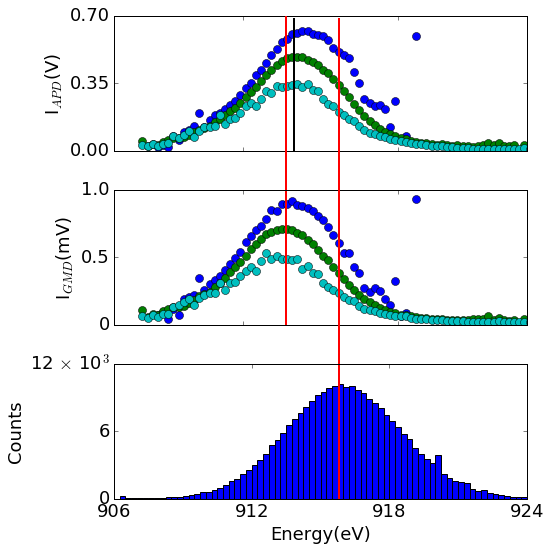

In [13]:
f, axarr = plt.subplots(3, sharex=True)

for i in [[.60,1],[.4,.56],[.0,.4]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],40,50)
    IvsE_moment = mean(nan_to_num(IvsFEE_average*e_bins[:-1]))/mean(nan_to_num(IvsFEE_average))
    I0vsE_moment = mean(nan_to_num(I0vsFEE_average*e_bins[:-1]))/mean(nan_to_num(I0vsFEE_average))
    axarr[0].plot(e_bins[:-1],IvsFEE_average,'o',markersize=8,alpha = 1.0)
    axarr[1].plot(e_bins[:-1],I0vsFEE_average,'o',markersize=8,alpha = 1.0)

energy_start_plot,energy_end_plot = 907,923
    
#axarr[0].set_xlabel("Energy(eV)")
axarr[0].set_ylabel("I$_{APD}$(V)")
axarr[0].set_xlim(energy_start_plot,energy_end_plot)
#axarr[0].axvline(x=IvsE_moment,color='r',linewidth=4)
axarr[0].axvline(x=IvsE_moment,color='k',linewidth=2,ymin=0,ymax=0.975,clip_on=False)
axarr[0].set_yticks(arange(0,0.71,0.7/2))
#axarr[0].set_yticklabels(["0","0.5","1.0"])

#axarr[1].set_xlabel("Energy(eV)")
axarr[1].set_ylabel("I$_{GMD}$(mV)")
axarr[1].set_xlim(energy_start_plot,energy_end_plot)
#axarr[1].axvline(x=I0vsE_moment,color='r',linewidth=4)
axarr[1].axvline(x=I0vsE_moment,color='r',linewidth=2,ymin=0,ymax=2.275,clip_on=False)
axarr[1].set_yticks(arange(0,0.0011,0.0005))
axarr[1].set_yticklabels(["0","0.5","1.0"])

axarr[2].hist(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25))
my_hist = histogram(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25))
#x_location = my_hist[1][argmax([my_hist[0]])]
x_location = mean(my_dict['ebeam/photon_energy'])
#axarr[2].axvline(x=x_location,color='r',linewidth=4)
axarr[2].axvline(x=x_location,color='r',linewidth=2,ymin=0,ymax=3.55,clip_on=False)

axarr[2].set_xlabel("Energy(eV)")
axarr[2].set_ylabel("Counts")

axarr[2].set_xlim(energy_start_plot,energy_end_plot)
axarr[2].set_xticks(arange(906,925,6))
axarr[2].set_xticklabels(["906","912","918","924"])


axarr[2].set_yticks(arange(0,12100,6000))
axarr[2].set_yticklabels(["0","6",r"12 $ \times $ 10$^3$"])
f.tight_layout()

show()

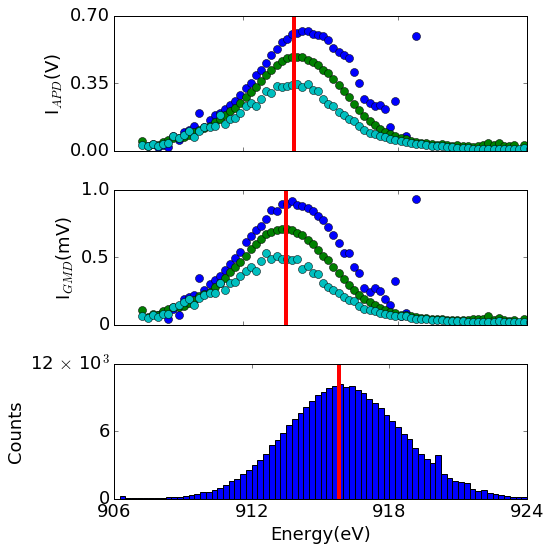

In [14]:
f, axarr = plt.subplots(3, sharex=True)

for i in [[.60,1],[.4,.56],[.0,.4]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],40,50)
    IvsE_moment = mean(nan_to_num(IvsFEE_average*e_bins[:-1]))/mean(nan_to_num(IvsFEE_average))
    I0vsE_moment = mean(nan_to_num(I0vsFEE_average*e_bins[:-1]))/mean(nan_to_num(I0vsFEE_average))
    axarr[0].plot(e_bins[:-1],IvsFEE_average,'o',markersize=8,alpha = 1.0)
    axarr[1].plot(e_bins[:-1],I0vsFEE_average,'o',markersize=8,alpha = 1.0)

energy_start_plot,energy_end_plot = 907,923
    
#axarr[0].set_xlabel("Energy(eV)")
axarr[0].set_ylabel("I$_{APD}$(V)")
axarr[0].set_xlim(energy_start_plot,energy_end_plot)
axarr[0].axvline(x=IvsE_moment,color='r',linewidth=4)
axarr[0].set_yticks(arange(0,0.71,0.7/2))
#axarr[0].set_yticklabels(["0","0.5","1.0"])

#axarr[1].set_xlabel("Energy(eV)")
axarr[1].set_ylabel("I$_{GMD}$(mV)")
axarr[1].set_xlim(energy_start_plot,energy_end_plot)
axarr[1].axvline(x=I0vsE_moment,color='r',linewidth=4)
axarr[1].set_yticks(arange(0,0.0011,0.0005))
axarr[1].set_yticklabels(["0","0.5","1.0"])

axarr[2].hist(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25))
my_hist = histogram(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25))
#x_location = my_hist[1][argmax([my_hist[0]])]
x_location = mean(my_dict['ebeam/photon_energy'])
axarr[2].axvline(x=x_location,color='r',linewidth=4)

axarr[2].set_xlabel("Energy(eV)")
axarr[2].set_ylabel("Counts")

axarr[2].set_xlim(energy_start_plot,energy_end_plot)
axarr[2].set_xticks(arange(906,925,6))
axarr[2].set_xticklabels(["906","912","918","924"])


axarr[2].set_yticks(arange(0,12100,6000))
axarr[2].set_yticklabels(["0","6",r"12 $ \times $ 10$^3$"])
f.tight_layout()

show()

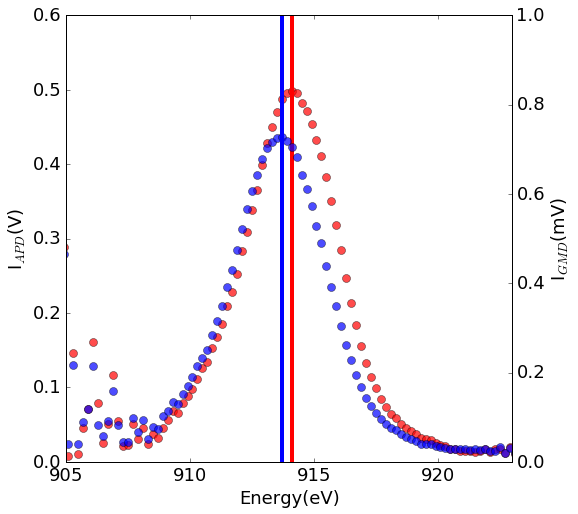

In [15]:
f3, axarr3 = plt.subplots(1, sharex=True)

IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(.3,.6,0,20)
axarr3.plot(e_bins[:-1],IvsFEE_average,'o',markersize=8,alpha = 0.7,color='r')
axarr3.set_xlabel("Energy(eV)")
axarr3.set_ylim(0,0.6)
axarr3.set_ylabel("I$_{APD}$(V)")
x_location = e_bins[argmax(nan_to_num(IvsFEE_average))]
axarr3.axvline(x=x_location,color='r',linewidth=4)
axarr4 = axarr3.twinx()
axarr4.plot(e_bins[:-1],I0vsFEE_average,'o',markersize=8,alpha = 0.7)
axarr4.set_ylabel("I$_{GMD}}$(mV)")
axarr4.set_ylim(0,0.001)
axarr4.set_xlim(energy_start_plot-2,energy_end_plot)
axarr4.set_yticks(arange(0,.0011,.0002))
axarr4.set_yticklabels(["0.0","0.2","0.4","0.6","0.8","1.0"])
x2_location = e_bins[argmax(nan_to_num(I0vsFEE_average))]
axarr4.axvline(x=x2_location,color='b',linewidth=4)

show()

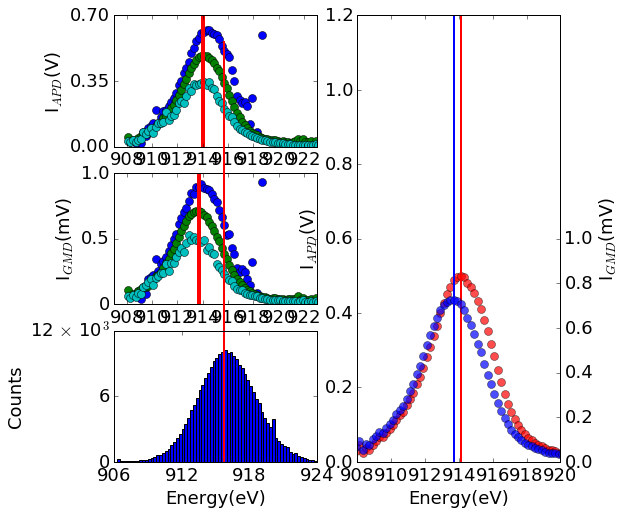

In [16]:
#f, axarr = plt.subplots(3, sharex=True)
axarr = [plt.subplot(321),plt.subplot(323),plt.subplot(325),plt.subplot(122)]

for i in [[.60,1],[.4,.56],[.0,.4]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],40,50)
    IvsE_moment = mean(nan_to_num(IvsFEE_average*e_bins[:-1]))/mean(nan_to_num(IvsFEE_average))
    I0vsE_moment = mean(nan_to_num(I0vsFEE_average*e_bins[:-1]))/mean(nan_to_num(I0vsFEE_average))
    axarr[0].plot(e_bins[:-1],IvsFEE_average,'o',markersize=8,alpha = 1.0)
    axarr[1].plot(e_bins[:-1],I0vsFEE_average,'o',markersize=8,alpha = 1.0)

energy_start_plot,energy_end_plot = 907,923
    
#axarr[0].set_xlabel("Energy(eV)")
axarr[0].set_ylabel("I$_{APD}$(V)")
axarr[0].set_xlim(energy_start_plot,energy_end_plot)
axarr[0].axvline(x=IvsE_moment,color='r',linewidth=4)
axarr[0].set_yticks(arange(0,0.71,0.7/2))
#axarr[0].set_yticklabels(["0","0.5","1.0"])

#axarr[1].set_xlabel("Energy(eV)")
axarr[1].set_ylabel("I$_{GMD}$(mV)")
axarr[1].set_xlim(energy_start_plot,energy_end_plot)
axarr[1].axvline(x=I0vsE_moment,color='r',linewidth=4)
axarr[1].set_yticks(arange(0,0.0011,0.0005))
axarr[1].set_yticklabels(["0","0.5","1.0"])

axarr[2].hist(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25))
my_hist = histogram(my_dict['ebeam/photon_energy'],bins= arange(905,925,.25))
#x_location = my_hist[1][argmax([my_hist[0]])]
x_location = mean(my_dict['ebeam/photon_energy'])
#axarr[2].axvline(x=x_location,color='r',linewidth=4)
axarr[2].axvline(x=x_location,color='r',linewidth=2,ymin=0,ymax=3.2,clip_on=False)

axarr[2].set_xlabel("Energy(eV)")
axarr[2].set_ylabel("Counts")

axarr[2].set_xlim(energy_start_plot,energy_end_plot)
axarr[2].set_xticks(arange(906,925,6))
axarr[2].set_xticklabels(["906","912","918","924"])


axarr[2].set_yticks(arange(0,12100,6000))
axarr[2].set_yticklabels(["0","6",r"12 $ \times $ 10$^3$"])
f.tight_layout()

#show()

axarr3 = plt.subplot(122)

IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(.3,.6,0,20)
axarr[3].plot(e_bins[:-1],IvsFEE_average,'o',markersize=8,alpha = 0.7,color='r')
axarr[3].set_xlabel("Energy(eV)")
axarr[3].set_ylim(0,1.2)
axarr[3].set_ylabel("I$_{APD}$(V)")
x_location = e_bins[argmax(nan_to_num(IvsFEE_average))]
axarr[3].axvline(x=x_location,color='r',linewidth=2)
axarr4 = axarr[3].twinx()
axarr4.plot(e_bins[:-1],I0vsFEE_average,'o',markersize=8,alpha = 0.7)
axarr4.set_ylabel("I$_{GMD}}$(mV)")
axarr4.set_ylim(0,0.002)
axarr4.set_xlim(908,920)
axarr4.set_yticks(arange(0,.0011,.0002))
axarr4.set_yticklabels(["0.0","0.2","0.4","0.6","0.8","1.0"])
x2_location = e_bins[argmax(nan_to_num(I0vsFEE_average))]
axarr4.axvline(x=x2_location,color='b',linewidth=2)

show()

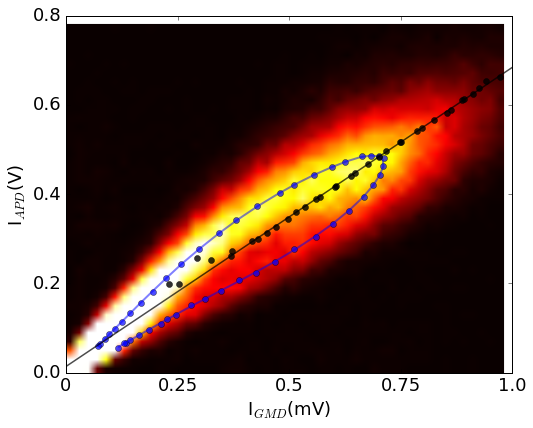

In [17]:
def gaussian(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+0.7e-4
    return a*exp(-(x-x0)**2/(2*sigma**2))

def gaussian_mod(offset):
    def gaussian(x, x0,sigma,a):
        return a*exp(-(x-x0)**2/(2*sigma**2))+offset
    return gaussian

my_colors = ['b','g','c']
axes = figure().add_subplot(111)
axes.imshow((IvsI0_hist[0][::-1,:]+1),cmap='hot',interpolation='bilinear',clim=(0,400),extent=(0,max(x_bins),0,max(y_bins)),aspect=1.0/1e3)
ylabel("I$_{APD}$(V)")
xlabel("I$_{GMD}$(mV)")
my_counter = 0 
#for i in [[.60,1],[.4,.56],[.0,.4]]:
for i in [[.4,.56]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],45,82)
    axes.plot(I0vsFEE_average,IvsFEE_average,'o',markersize=6,alpha = 0.7,color=my_colors[my_counter])
    poptIvsFee, pcovIvsFee = curve_fit(gaussian, e_bins[:-1],IvsFEE_average,p0=[914,5,1])
    poptI0vsFee, pcovI0vsFee = curve_fit(gaussian, e_bins[:-1],I0vsFEE_average,p0=[914,5,.001])
    axes.plot(savgol_filter(I0vsFEE_average,11,3),savgol_filter(IvsFEE_average,11,3),alpha=0.5,linewidth=2,color=my_colors[my_counter])
    #poptIvsFee, pcovIvsFee = curve_fit(gaussian_mod(-0.00), e_bins[:-1],IvsFEE_average,p0=[914,5,1])
    #poptI0vsFee, pcovI0vsFee = curve_fit(gaussian_mod(-1e-5), e_bins[:-1],I0vsFEE_average,p0=[914,5,.001])
    #axes.plot(gaussian(e_bins,*poptI0vsFee),gaussian(e_bins,*poptIvsFee),alpha=0.5,linewidth=4,color=my_colors[my_counter])
    
    my_counter +=1

axes.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'k-',linewidth=1.5,alpha=0.7)
axes.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'ko',alpha=50)
axes.set_xlim(0,0.001)
axes.set_ylim(0,0.8)
axes.set_xticks(arange(0,0.0011,0.00025))
axes.set_xticklabels(["0","0.25","0.5","0.75","1.0"])
axes.set_yticks(arange(0,0.9,0.2))
show()

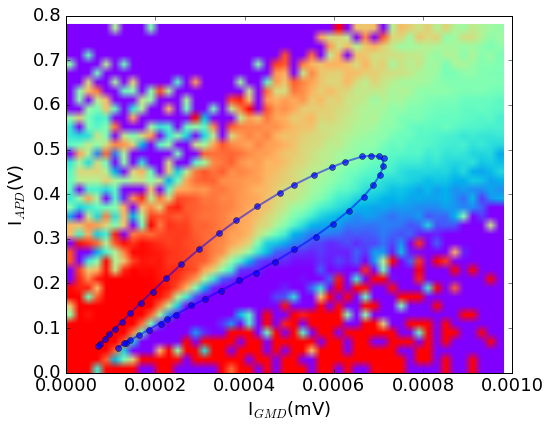

In [55]:
fee_mask = array(fee<0.8)
IvsI0_hist = binned_statistic_dd([y[fee_mask],x[fee_mask]],my_dict['ebeam/photon_energy'][my_mask][fee_mask],bins=[y_bins,x_bins],statistic='mean')
#IvsI0_hist = binned_statistic_dd([y,x],my_dict['ebeam/photon_energy'][my_mask],bins=[y_bins,x_bins],statistic='mean')
#IvsI0_hist = binned_statistic_dd([y,x],fee,bins=[y_bins,x_bins],statistic='mean')
def gaussian(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+0.7e-4
    return a*exp(-(x-x0)**2/(2*sigma**2))

def gaussian_mod(offset):
    def gaussian(x, x0,sigma,a):
        return a*exp(-(x-x0)**2/(2*sigma**2))+offset
    return gaussian

my_colors = ['b','g','c']
axes = figure().add_subplot(111)
axes.imshow((nan_to_num(IvsI0_hist[0][::-1,:])),cmap='rainbow',interpolation='bilinear',clim=(912,916.5),extent=(0,max(x_bins),0,max(y_bins)),aspect=1.0/1e3)
ylabel("I$_{APD}$(V)")
xlabel("I$_{GMD}$(mV)")
my_counter = 0 
#for i in [[.60,1],[.4,.56],[.0,.4]]:
for i in [[.4,.56]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],45,82)
    axes.plot(I0vsFEE_average,IvsFEE_average,'o',markersize=6,alpha = 0.7,color=my_colors[my_counter])
    poptIvsFee, pcovIvsFee = curve_fit(gaussian, e_bins[:-1],IvsFEE_average,p0=[914,5,1])
    poptI0vsFee, pcovI0vsFee = curve_fit(gaussian, e_bins[:-1],I0vsFEE_average,p0=[914,5,.001])
    axes.plot(savgol_filter(I0vsFEE_average,11,3),savgol_filter(IvsFEE_average,11,3),alpha=0.5,linewidth=2,color=my_colors[my_counter])
    #poptIvsFee, pcovIvsFee = curve_fit(gaussian_mod(-0.00), e_bins[:-1],IvsFEE_average,p0=[914,5,1])
    #poptI0vsFee, pcovI0vsFee = curve_fit(gaussian_mod(-1e-5), e_bins[:-1],I0vsFEE_average,p0=[914,5,.001])
    #axes.plot(gaussian(e_bins,*poptI0vsFee),gaussian(e_bins,*poptIvsFee),alpha=0.5,linewidth=4,color=my_colors[my_counter])
    
    my_counter +=1

#axes.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'k-',linewidth=1.5,alpha=0.7)
#axes.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'ko',alpha=50)
#axes.set_xlim(0,0.001)
#axes.set_ylim(0,0.8)
#axes.set_xticks(arange(0,0.0011,0.00025))
#axes.set_xticklabels(["0","0.25","0.5","0.75","1.0"])
#axes.set_yticks(arange(0,0.9,0.2))
show()

In [42]:
fee_mask

array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

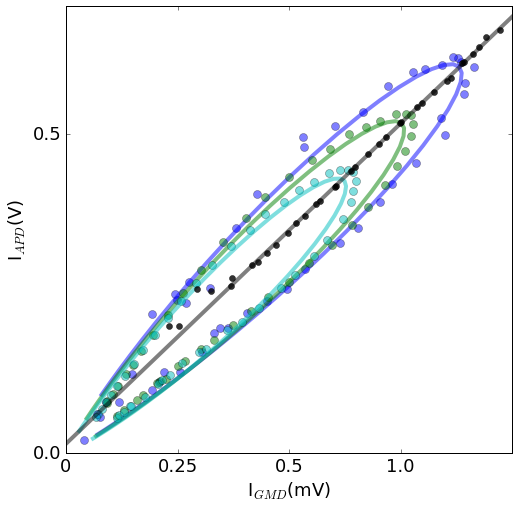

In [18]:
my_colors = ['b','g','c']
axes = figure().add_subplot(111)
#axes.imshow((IvsI0_hist[0][::-1,:]+1),cmap='hot',interpolation='bilinear',clim=(0,400),extent=(0,0.0012,0,1),aspect=1.0/1e3)
ylabel("I$_{APD}$(V)")
xlabel("I$_{GMD}$(mV)")
my_counter = 0 
for i in [[.60,1],[.5,.6],[.3,.5]]:
    IvsFEE_average,I0vsFEE_average,e_bins = make_IvsI0(i[0],i[1],45,82)
    axes.plot(I0vsFEE_average,IvsFEE_average,'o',markersize=8,alpha = 0.5,color=my_colors[my_counter])
    poptIvsFee, pcovIvsFee = curve_fit(gaussian, e_bins[:-1],IvsFEE_average,p0=[914,5,1])
    poptI0vsFee, pcovI0vsFee = curve_fit(gaussian, e_bins[:-1],I0vsFEE_average,p0=[914,5,.001])
    axes.plot(gaussian(e_bins,*poptI0vsFee),gaussian(e_bins,*poptIvsFee),alpha=0.5,linewidth=4,color=my_colors[my_counter])
    
    my_counter +=1

axes.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'k-',linewidth=4,alpha=0.5)
axes.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'ko',alpha=50)
axes.set_xlim(0,0.001)
axes.set_xticks(arange(0,0.0011,0.00025))
axes.set_xticklabels(["0","0.25","0.5","1.0"])
axes.set_yticks(arange(0,1.1,0.5))
axes.set_ylim(0,.7)
show()